In [89]:
import pandas as pd
import numpy as np

from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.datasets import make_moons, load_iris, load_diabetes

import matplotlib.pyplot as plt

import joblib
import torch
import pickle
import warnings

In [90]:
pd.options.mode.chained_assignment = None
warnings.simplefilter(action='ignore', category=FutureWarning)

with open("Amazon_products.pkl", 'rb') as f:
    dt = pickle.load(f)

In [91]:
dt

,asin,title,price,list_price,rating,reviews,sold_past_month,is_bestseller,is_prime,is_amazon_choice,has_sustainability_features,available_offers,amazon_choice_type,brand,free_delivery_date,fastest_delivery_date
0,B0DJK7NW1J,"15.6 Inch Laptops, Windows 11 Laptop Computers...",199.98,679.99,4.4 out of 5 stars,48,100+,False,False,False,False,NaN,NaN,NaN,NaN,NaN
1,B0BS4BP8FB,Acer Aspire 3 A315-24P-R7VH Slim Laptop | 15.6...,279.99,321.99,4.4 out of 5 stars,"39,243",8K+,False,False,True,False,6,Overall Pick,NaN,NaN,NaN
2,B0DKDY78K3,"Newest Gaming Laptop, Laptop with AMD Ryzen 7 ...",649.99,"1,699.99",4.8 out of 5 stars,18,100+,False,False,False,False,NaN,NaN,NaN,NaN,NaN
3,B0CPL25J3W,"HP Portable Laptop, Student and Business, 14"" ...",197.35,269.00,4.1 out of 5 stars,"1,678",1K+,False,False,False,False,25,NaN,NaN,NaN,NaN
4,B0947BJ67M,"HP 14 Laptop, Intel Celeron N4020, 4 GB RAM, 6...",176.00,209.99,4.0 out of 5 stars,"1,861",4K+,False,False,False,False,50,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1237,B0B5GRGCX5,"Lenovo L15 Portable Monitor, 15.6” Display, Fu...",162.00,180.44,4.3 out of 5 stars,46,500+,False,False,False,False,28,NaN,NaN,NaN,NaN
1238,B0CH9XW8RK,ARZOPA Portable Monitor 15.6'' FHD 1080P - Ult...,85.99,NaN,4.4 out of 5 stars,"1,092",3K+,False,True,False,False,4,NaN,NaN,"Tue, Nov 19",NaN
1239,B0CY896H5G,"Laptop Screen Extender 14"" 1080P FHD IPS, Port...",299.99,NaN,4.4 out of 5 stars,422,1K+,False,True,False,False,3,NaN,NaN,"Tue, Nov 19",NaN
1240,B0C77WJ6F5,Yodoit Portable Monitor for Laptop 1920×1080 1...,49.99,69.99,4.0 out of 5 stars,416,1K+,False,True,False,False,NaN,NaN,NaN,"Tue, Nov 19",NaN


In [92]:
all_dt = dt[["price", "list_price", "rating", "sold_past_month", "reviews", "is_bestseller", "is_prime", "is_amazon_choice", "available_offers"]]

In [93]:
def str_to_float(s):
    if isinstance(s, str):
        s = float("".join(s.split(',')))
    return s

def stars_to_rating(s):
    if isinstance(s, str):
        r = float(s.split()[0])
        return r
    return s


def to_bool(s):
  return int(s)

def spm(s):
    if isinstance(s, str):
        if s[-2] == "K":
            return int(s[:-2]) * 1000
        return int(s[:-1])
    return s

In [94]:
all_dt.dropna(inplace=True, subset=['list_price'])

In [95]:
def upd_dt(X):
    X["price"] = X["price"].apply(str_to_float)
    X["list_price"] = X["list_price"].apply(str_to_float)
    X["rating"] = X['rating'].apply(stars_to_rating)
    X['sold_past_month'] = X['sold_past_month'].apply(spm)
    X['reviews'] = X['reviews'].apply(str_to_float)
    X["available_offers"] = X["available_offers"].apply(str_to_float)
    X['is_bestseller'] = X['is_bestseller'].apply(to_bool)
    X['is_prime'] = X['is_prime'].apply(to_bool)
    X['is_amazon_choice'] = X['is_amazon_choice'].apply(to_bool)
    return X

all_dt = upd_dt(all_dt)

In [96]:
def fill_na(x, col_n):
  mean_val = x[col_n].mean()
  if col_n == 'available_offers':
    mean_val = 0
  x[col_n].fillna(mean_val, inplace=True)


for n in all_dt:
    fill_na(all_dt, n)

In [97]:
all_dt['price'] = all_dt[['list_price', 'price']].apply(lambda x: x['price'] if x['list_price'] > x['price'] else x['list_price'], axis=1)
all_dt['diff_price'] = all_dt['list_price'] - all_dt['price']
all_dt['log_price'] = np.log2(all_dt['price'] )

# mtm = more_than_mean
all_dt['reviews_mtm'] = all_dt['reviews'].apply(lambda x: int(x > all_dt['reviews'].mean()))
# all_dt['price_mtm'] = all_dt['price'].apply(lambda x: int(x > all_dt['price'].mean()))
all_dt['spm_mtm'] = all_dt['sold_past_month'].apply(lambda x: int(x > all_dt['sold_past_month'].mean()))
all_dt['avaliable_offers_mtm'] = all_dt['available_offers'].apply(lambda x: int(x > all_dt['available_offers'].mean()))
# all_dt['is_bestseller_and_prime'] = all_dt['is_bestseller'] * all_dt['is_prime']

all_dt

,price,list_price,rating,sold_past_month,reviews,is_bestseller,is_prime,is_amazon_choice,available_offers,diff_price,log_price,reviews_mtm,spm_mtm,avaliable_offers_mtm
0,199.98,679.99,4.4,100.0,48.0,0,0,0,0.0,480.01,7.643712,0,0,0
1,279.99,321.99,4.4,8000.0,39243.0,0,0,1,6.0,42.00,8.129231,1,1,0
2,649.99,1699.99,4.8,100.0,18.0,0,0,0,0.0,1050.00,9.344274,0,0,0
3,197.35,269.00,4.1,1000.0,1678.0,0,0,0,25.0,71.65,7.624613,0,0,1
4,176.00,209.99,4.0,4000.0,1861.0,0,0,0,50.0,33.99,7.459432,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1226,69.99,129.99,4.4,10000.0,9149.0,0,1,1,0.0,60.00,6.129077,1,1,0
1227,79.99,89.98,4.5,10000.0,7906.0,1,1,0,7.0,9.99,6.321748,0,1,0
1234,83.99,99.99,4.9,500.0,93.0,0,1,0,0.0,16.00,6.392146,0,0,0
1237,162.00,180.44,4.3,500.0,46.0,0,0,0,28.0,18.44,7.339850,0,0,1


In [98]:
X = torch.Tensor(all_dt[["price", "rating", "sold_past_month", "reviews", "is_bestseller", "is_prime", "is_amazon_choice", "available_offers", "diff_price"]].to_numpy())
y = torch.Tensor(all_dt["list_price"].to_numpy())

In [99]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [100]:
class OurNonLinearNet(torch.nn.Module):
    loss_fun = torch.nn.MSELoss(reduction="sum")
    def __init__(self, input_features, out_features, hidden_units):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_features, hidden_units)
        self.relu1 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_units, hidden_units)
        self.relu2 = torch.nn.ReLU()
        self.fc3 = torch.nn.Linear(hidden_units, out_features)
        self.optimizer = torch.optim.Adam(self.parameters(), lr=0.0009)


    def forward(self, x):
        x = self.relu1(self.fc1(x))
        x = self.relu2(self.fc2(x))
        x = self.fc3(x)
        return x


    def fit(self, X, y, n_epochs=1000, print_loss=True):
        for epoch in range(n_epochs+1):

            self.train()
            y_logits = self(X).squeeze()
            loss = self.loss_fun(y_logits, y)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            if print_loss and (epoch % 20 == 0):
                print(f"Epoch {epoch}: loss = {loss:.5f}")

    def predict(self, x):
        return self.forward(x)


    def predict_from_logit(self, x_logit):
        return torch.round(torch.sigmoid(x_logit))

In [101]:
net = OurNonLinearNet(9, 1, 800)

In [102]:
net.fit(X_train, y_train, n_epochs=15_000)

Epoch 0: loss = 313730592.00000
Epoch 20: loss = 686960000.00000
Epoch 40: loss = 30142270.00000
Epoch 60: loss = 7939091.00000
Epoch 80: loss = 3567911.50000
Epoch 100: loss = 734794.62500
Epoch 120: loss = 266582.25000
Epoch 140: loss = 158844.81250
Epoch 160: loss = 117626.34375
Epoch 180: loss = 97806.71094
Epoch 200: loss = 79942.72656
Epoch 220: loss = 71013.63281
Epoch 240: loss = 60101.24609
Epoch 260: loss = 57429.82031
Epoch 280: loss = 45616.29688
Epoch 300: loss = 42746.94141
Epoch 320: loss = 35747.24219
Epoch 340: loss = 33023.67969
Epoch 360: loss = 28495.34766
Epoch 380: loss = 28389.31445
Epoch 400: loss = 24337.92578
Epoch 420: loss = 45232.65234
Epoch 440: loss = 50403.06641
Epoch 460: loss = 23278.93750
Epoch 480: loss = 20695.89258
Epoch 500: loss = 18188.46484
Epoch 520: loss = 14229.32910
Epoch 540: loss = 115448.30469
Epoch 560: loss = 79226.04688
Epoch 580: loss = 21457.83398
Epoch 600: loss = 13679.93359
Epoch 620: loss = 10911.74316
Epoch 640: loss = 9695.130

tensor(3.1778, grad_fn=<MseLossBackward0>)


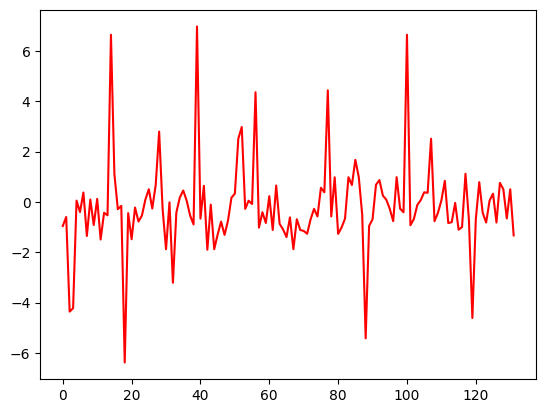

In [105]:
print(torch.nn.MSELoss()(y_test, net(X_test).squeeze()))


plt.plot(range(len(y_test)), y_test.detach().numpy() -  net(X_test).squeeze().detach().numpy(), c="r")
#plt.scatter(range(len(y_test)),, c="b")
plt.show()

In [104]:
net(X_test).squeeze()

tensor([1400.9431,  739.5966,  334.3450,   13.2096,  279.9368,   90.3811,
         379.6148,   22.1012,  159.8931,  106.9048,   39.8679,  121.4606,
          20.4189,   16.5212,  123.3476,   58.8861,  290.2760,   90.2448,
          32.3651,  889.4440,   47.7716,  162.2114,   46.5477,   40.5290,
         849.8938,   69.4839,   20.2504,  299.3176,  227.1957,  350.2543,
          21.8663,   20.0048,  203.1980, 1300.4119,  399.8134,  879.5359,
         279.9368,   40.5290,   10.8819,  123.0200,   24.6519,   68.1477,
          38.8866,   20.9243,   21.8663,   31.2817,   21.7705,   23.2998,
          80.7326,  298.8334,   78.6659,  217.4762,  187.0128,  900.2661,
         179.9399,  674.0806,  225.6326,  160.0190,  118.3965,   12.8248,
         229.7582, 1601.1038,  149.3357,   30.8603,   41.0805,   11.3850,
         100.6035,   21.8663,  780.6755,  121.0831,  437.0519,  101.2320,
          14.6798,  100.2622,  131.9260,   99.4247,  209.6054,  205.5559,
         131.9260,   34.0098,  101.258